In [2]:
import os
import math
import time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


100%|██████████| 170M/170M [00:04<00:00, 35.3MB/s] 


Showing Input (Grayscale) and Target (Color) pairs:


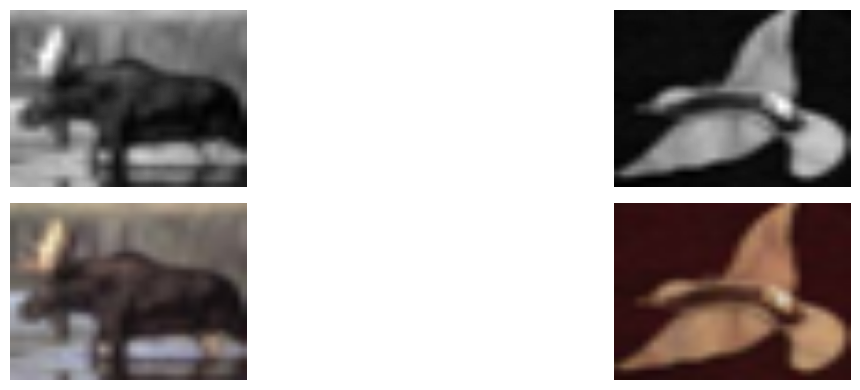


Dataset Information:
Grayscale Input shape:  torch.Size([2, 1, 240, 320])
Color Target shape:     torch.Size([2, 3, 120, 160])
Training samples:       50000
Test samples:           10000

Example usage in training loop:
------------------------------------------------------------
Batch 1:
  Input (grayscale):  torch.Size([2, 1, 240, 320])
  Target (color):     torch.Size([2, 3, 120, 160])
Batch 2:
  Input (grayscale):  torch.Size([2, 1, 240, 320])
  Target (color):     torch.Size([2, 3, 120, 160])
Batch 3:
  Input (grayscale):  torch.Size([2, 1, 240, 320])
  Target (color):     torch.Size([2, 3, 120, 160])
------------------------------------------------------------


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Transform for grayscale input
transform_grayscale = transforms.Compose([
    transforms.Resize((240, 320)),
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel grayscale
    transforms.ToTensor(),
])

# Transform for color output (original RGB image)
transform_color = transforms.Compose([
    transforms.Resize((120, 160)),
    transforms.ToTensor(),
])

# Custom Dataset that returns both grayscale and color versions
class CIFAR10Colorization(torch.utils.data.Dataset):
    def __init__(self, root='./data', train=True, download=True):
        # Load the original CIFAR-10 dataset
        self.cifar10 = torchvision.datasets.CIFAR10(
            root=root,
            train=train,
            download=download,
            transform=None  # We'll apply transforms manually
        )
        
        self.transform_gray = transform_grayscale
        self.transform_color = transform_color
        
    def __len__(self):
        return len(self.cifar10)
    
    def __getitem__(self, idx):
        # Get the original PIL image
        image, _ = self.cifar10[idx]
        
        # Create grayscale version (input)
        gray_image = self.transform_gray(image)
        
        # Create color version (target/output)
        color_image = self.transform_color(image)
        
        return gray_image, color_image

# Create datasets
trainset = CIFAR10Colorization(root='./data', train=True, download=True)
testset = CIFAR10Colorization(root='./data', train=False, download=True)

# Create data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=2,
    shuffle=True, 
    num_workers=2,
    pin_memory = True
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=2,
    shuffle=False, 
    num_workers=2,
    pin_memory = True
)

# Visualize grayscale inputs and color outputs
def show_image_pairs(loader, num_images=2):
    dataiter = iter(loader)
    gray_images, color_images = next(dataiter)
    
    fig, axes = plt.subplots(2, num_images, figsize=(16, 4))
    
    for idx in range(num_images):
        # Grayscale input (top row)
        gray_img = gray_images[idx].squeeze()  # Remove channel dimension
        axes[0, idx].imshow(gray_img, cmap='gray')
        axes[0, idx].axis('off')
        
        # Color output/target (bottom row)
        color_img = color_images[idx].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
        axes[1, idx].imshow(color_img)
        axes[1, idx].axis('off')
    
    # Add row labels
    axes[0, 0].set_ylabel('Input\n(Grayscale)', fontsize=12, rotation=0, labelpad=50)
    axes[1, 0].set_ylabel('Target\n(Color)', fontsize=12, rotation=0, labelpad=50)
    
    plt.tight_layout()
    plt.show()

# Display image pairs
print("Showing Input (Grayscale) and Target (Color) pairs:")
show_image_pairs(trainloader)

# Get a batch to check the shapes
dataiter = iter(trainloader)
gray_images, color_images = next(dataiter)

print(f"\n{'='*60}")
print(f"Dataset Information:")
print(f"{'='*60}")
print(f"Grayscale Input shape:  {gray_images.shape}")  # [batch, 1, 240, 320]
print(f"Color Target shape:     {color_images.shape}")  # [batch, 3, 120, 160]
print(f"Training samples:       {len(trainset)}")
print(f"Test samples:           {len(testset)}")
print(f"{'='*60}")

# Example: How to use in training loop
print("\nExample usage in training loop:")
print("-" * 60)
for batch_idx, (gray_input, color_target) in enumerate(trainloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Input (grayscale):  {gray_input.shape}")
    print(f"  Target (color):     {color_target.shape}")
    
    # Your model would use:
    # output = model(gray_input)  # Model predicts color image
    # loss = criterion(output, color_target)  # Compare with original color
    
    if batch_idx == 2:  # Show just first 3 batches as example
        break

print("-" * 60)

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

class ImageColorModel(nn.Module):
    def __init__(self):
        super(ImageColorModel, self).__init__()
        
        # resnet = models.resnet50(pretrained=True)
        densenet = models.densenet161(pretrained=True)

        for param in densenet.parameters():
              param.requires_grad = False

        self.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.norm0 = densenet.features.norm0
        self.relu0 = densenet.features.relu0
        self.pool0 = densenet.features.pool0

        self.denseblock1 = densenet.features.denseblock1
        
        self.transition1 = densenet.features.transition1

        self.denseblock2 = densenet.features.denseblock2

        self.transition2 = densenet.features.transition2

        self.denseblock3 = densenet.features.denseblock3
        
        self.transition3 = densenet.features.transition3

        self.denseblock4 = densenet.features.denseblock4

        self.norm5 = densenet.features.norm5

        self.botl1 = nn.Sequential(
            densenet.features.transition1.norm,
            densenet.features.transition1.relu,
            nn.Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )

        self.botl2 = nn.Sequential(
            densenet.features.transition2.norm,
            densenet.features.transition2.relu,
            nn.Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )

        self.botl3 = nn.Sequential(
            densenet.features.transition3.norm,
            densenet.features.transition3.relu,
            nn.Conv2d(2112, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )

        self.botl4 = nn.Sequential(
            nn.BatchNorm2d(2208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(2208, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )

        self.dcl1 = nn.Sequential(
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=(1,2), output_padding=0),
            nn.AvgPool2d(kernel_size=(1,2), stride=1, padding=(0,1))
        )
        
        self.dcl2 = nn.Sequential(
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 128, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.AvgPool2d(kernel_size=2, stride=1, padding=1)
        )

        self.dcl3 = nn.Sequential(
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 64, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.AvgPool2d(kernel_size=2, stride=1, padding=1)
        )

        self.dcl4 = nn.Sequential(
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.AvgPool2d(kernel_size=2, stride=1, padding=1)
        )

        # self.cat = torch.cat([x, y])
        
    def forward(self, data):
        data = self.conv0(data)
        data = self.norm0(data)
        data = self.relu0(data)
        data = self.pool0(data)

        db6 = self.denseblock1(data)
        db12= self.transition1(db6) 
        db12 = self.denseblock2(db12)
        db36 = self.transition2(db12)
        db36 = self.denseblock3(db36) 
        dense_data = self.transition3(db36)
        dense_data = self.denseblock4(dense_data) 
        dense_data = self.norm5(dense_data)

        output = self.botl4(dense_data)
        output = self.dcl1(output)

        db36 = self.botl3(db36)        
        output = torch.cat([output, db36], dim = 1)

        output = self.dcl2(output)

        db12 = self.botl2(db12)
        output = torch.cat([output, db12], dim = 1)

        output = self.dcl3(output)

        db6 = self.botl1(db6)
        output = torch.cat([output, db6], dim = 1)

        output = self.dcl4(output)
        
        return output

In [5]:
learning_rate = 0.001
epochs = 5

In [6]:
import torch.optim as optim

model = ImageColorModel()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 216MB/s] 


In [7]:
trainloader

In [ ]:
from tqdm import tqdm

# training loop

LOSS = []

for epoch in range(epochs):

  total_epoch_loss = 0

  # pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

  # for batch_idx, (batch_features, batch_labels) in tqdm(trainloader):
  for batch_features, batch_labels in tqdm(trainloader):

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()
    

  avg_loss = total_epoch_loss/len(train_loader)
  LOSS.append(avg_loss)  
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

 64%|██████▎   | 15929/25000 [18:51<10:27, 14.46it/s]